In [ ]:
!pip install powerlaw

## SIR SImulation is not important

=== Barabási-Albert Network Analysis ===
Average Shortest Path Length: 3.501
Average Clustering Coefficient: 0.028
Diameter: 6
Degree Assortativity Coefficient: -0.076
Minimum Degree: 3
Maximum Degree: 81
Average Degree: 5.982
Power-law Exponent: 3.042
Power-law xmin: 6.0
Top 5 Hubs by Betweenness: [0, 4, 8, 6, 7]
Largest Component after 20% Random Removal: 800
Largest Component after 20% Targeted Removal: 1000
Max Infected in SIR: 689
Number of Communities: 16
Modularity: 0.385


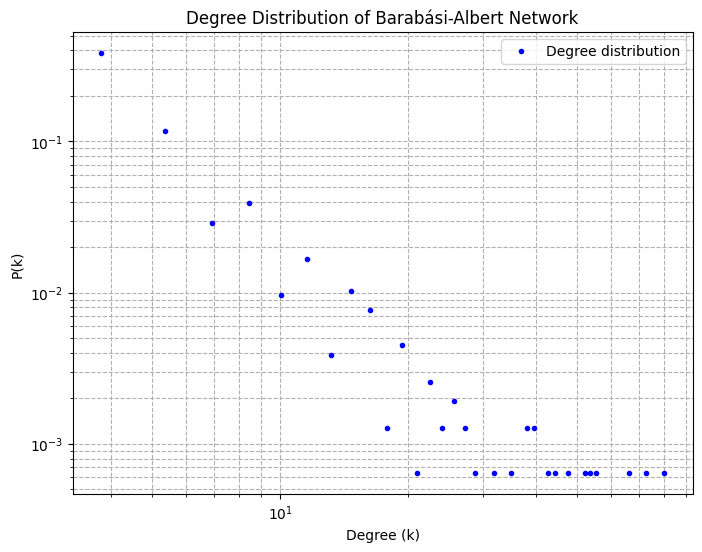

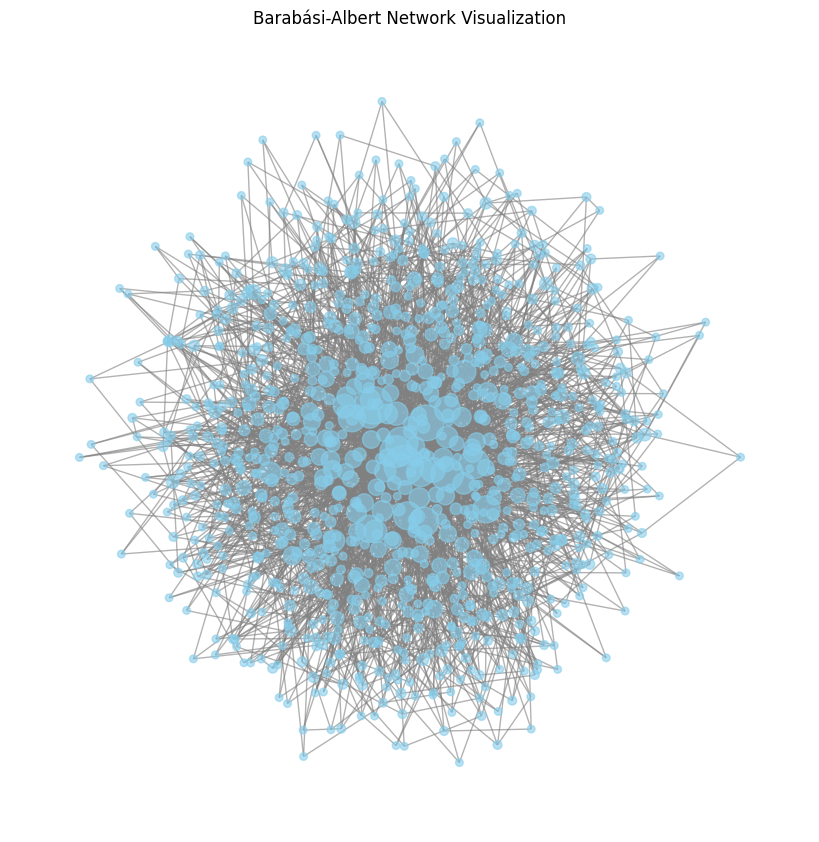

In [ ]:
#1 the General Working and Syntaxes for BA network and its metrics

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from powerlaw import Fit

# Generate Barabási-Albert network
n = 1000  # Number of nodes
m = 3     # Number of edges to attach from a new node to existing nodes
G = nx.barabasi_albert_graph(n, m)

# Basic network metrics
avg_path_length = nx.average_shortest_path_length(G)
avg_clustering = nx.average_clustering(G)
diameter = nx.diameter(G)
assortativity = nx.degree_assortativity_coefficient(G)

# Degree statistics
degrees = [d for n, d in G.degree()]
min_degree = min(degrees)
max_degree = max(degrees)
avg_degree = np.mean(degrees)

# Power-law fit for degree distribution
fit = Fit(degrees, verbose=False)
power_law_alpha = fit.power_law.alpha
power_law_xmin = fit.power_law.xmin

# Degree distribution histogram
hist, bin_edges = np.histogram(degrees, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
valid = hist > 0  # Filter for log-log plot

# Centrality measures
betweenness = nx.betweenness_centrality(G)
top_hubs = sorted(betweenness, key=betweenness.get, reverse=True)[:5]

# Percolation analysis (robustness to targeted node removal)
def percolation(G, fraction, targeted=False):
    G_copy = G.copy()
    if targeted:
        nodes_to_remove = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
    else:
        nodes_to_remove = list(G_copy.nodes())
        np.random.shuffle(nodes_to_remove)
    num_remove = int(fraction * len(G_copy))
    G_copy.remove_nodes_from(nodes_to_remove[:num_remove])
    components = list(nx.connected_components(G_copy))
    return len(max(components, key=len, default=set()))  # Size of largest component

largest_component_random = percolation(G, 0.2, targeted=False)
largest_component_targeted = percolation(G, 0.2, targeted=True)

# SIR simulation
def sir_simulation(G, beta=0.1, gamma=0.05, steps=100):
    status = {n: 'S' for n in G}
    status[0] = 'I'  # Start with node 0 infected
    infected_count = []
    for _ in range(steps):
        new_status = status.copy()
        for n in G:
            if status[n] == 'I':
                for neighbor in G.neighbors(n):
                    if status[neighbor] == 'S' and np.random.rand() < beta:
                        new_status[neighbor] = 'I'
                if np.random.rand() < gamma:
                    new_status[n] = 'R'
        status = new_status
        infected_count.append(sum(1 for s in status.values() if s == 'I'))
    return max(infected_count)

max_infected = sir_simulation(G)

# Community detection
from networkx.algorithms.community import greedy_modularity_communities
communities = greedy_modularity_communities(G)
num_communities = len(communities)
modularity = nx.community.modularity(G, communities)

# Print results
print("=== Barabási-Albert Network Analysis ===")
print(f"Average Shortest Path Length: {avg_path_length:.3f}")
print(f"Average Clustering Coefficient: {avg_clustering:.3f}")
print(f"Diameter: {diameter}")
print(f"Degree Assortativity Coefficient: {assortativity:.3f}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Power-law Exponent: {power_law_alpha:.3f}")
print(f"Power-law xmin: {power_law_xmin}")
print(f"Top 5 Hubs by Betweenness: {top_hubs}")
print(f"Largest Component after 20% Random Removal: {largest_component_random}")
print(f"Largest Component after 20% Targeted Removal: {largest_component_targeted}")
print(f"Max Infected in SIR: {max_infected}")
print(f"Number of Communities: {num_communities}")
print(f"Modularity: {modularity:.3f}")

# Plot degree distribution
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers[valid], hist[valid], 'b.', label='Degree distribution')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Distribution of Barabási-Albert Network')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Plot network visualization
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
node_sizes = [d * 10 for n, d in G.degree()]  # Scale for visibility
nx.draw(G, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', alpha=0.6)
plt.title('Barabási-Albert Network Visualization')
plt.show()

PSEUDOCODE FOR BA Network

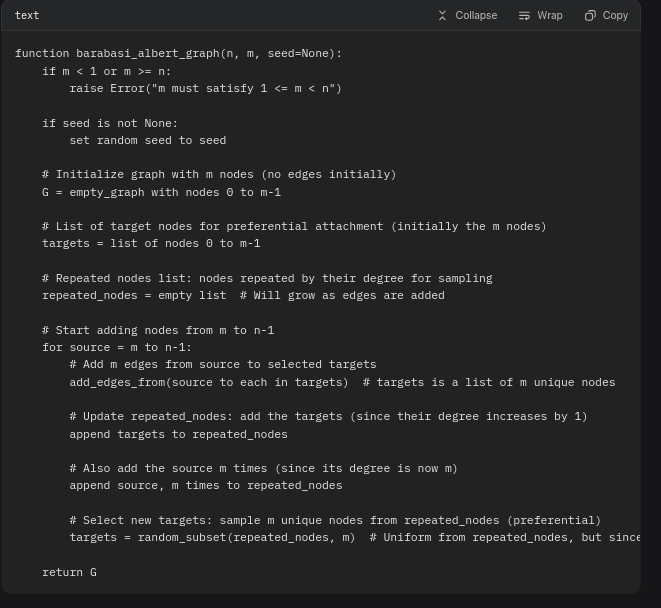

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def random_subset(repeated_nodes, m):
    """Select m unique elements from repeated_nodes with replacement initially, but ensure uniqueness."""
    selected = set()
    while len(selected) < m:
        idx = random.randint(0, len(repeated_nodes) - 1)
        selected.add(repeated_nodes[idx])
    return list(selected)

def barabasi_albert_graph(n, m, seed=None):
    """Generate a Barabási-Albert graph with n nodes and m edges per new node."""
    if m < 1 or m >= n:
        raise ValueError(f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}")

    if seed is not None:
        random.seed(seed)

    G = {}
    for i in range(m):
        G[i] = []

    targets = list(range(m))

    # Repeated nodes for preferential attachment
    repeated_nodes = []

    # Start adding nodes from m to n-1
    source = m
    while source < n:
        G[source] = []
        for target in targets:
            G[source].append(target)
            G[target].append(source)
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)
        targets = random_subset(repeated_nodes, m)
        source += 1

    return G

# Generate BA graph
graph = barabasi_albert_graph(n=1000, m=3, seed=None)

# Convert dictionary to NetworkX graph
G_nx = nx.Graph()
for node in graph:
    for neighbor in graph[node]:
        G_nx.add_edge(node, neighbor)

# Calculate network metrics
avg_path_length = nx.average_shortest_path_length(G_nx)
avg_clustering = nx.average_clustering(G_nx)
diameter = nx.diameter(G_nx)

# Degree statistics without list comprehension
degrees = []
for node, deg in G_nx.degree():
    degrees.append(deg)
avg_degree = np.mean(degrees)
min_degree = min(degrees)
max_degree = max(degrees)

# Print results
print("=== Barabási-Albert Network Analysis ===")
print(f"Average Shortest Path Length: {avg_path_length:.3f}")
print(f"Average Clustering Coefficient: {avg_clustering:.3f}")
print(f"Diameter: {diameter}")
print(f"Average Degree: {avg_degree:.3f}")
print(f"Minimum Degree: {min_degree}")
print(f"Maximum Degree: {max_degree}")

# Visualize the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_nx)
# Node sizes scaled by degree without list comprehension
node_sizes = []
for node, deg in G_nx.degree():
    node_sizes.append(deg * 10)  # Scale for visibility
nx.draw(G_nx, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', alpha=0.6)
plt.title('Barabási-Albert Network Visualization (n=1000, m=3)')
plt.show()

## Robustness Can also be done using networkx robustness please see the networkx robustnes code first, and then look at this

=== Robustness Exercises in Complex Networks ===
Networks generated: ER, BA, WS
BA Random Failure Threshold: 0.88
ER Theoretical Random Threshold: 0.84


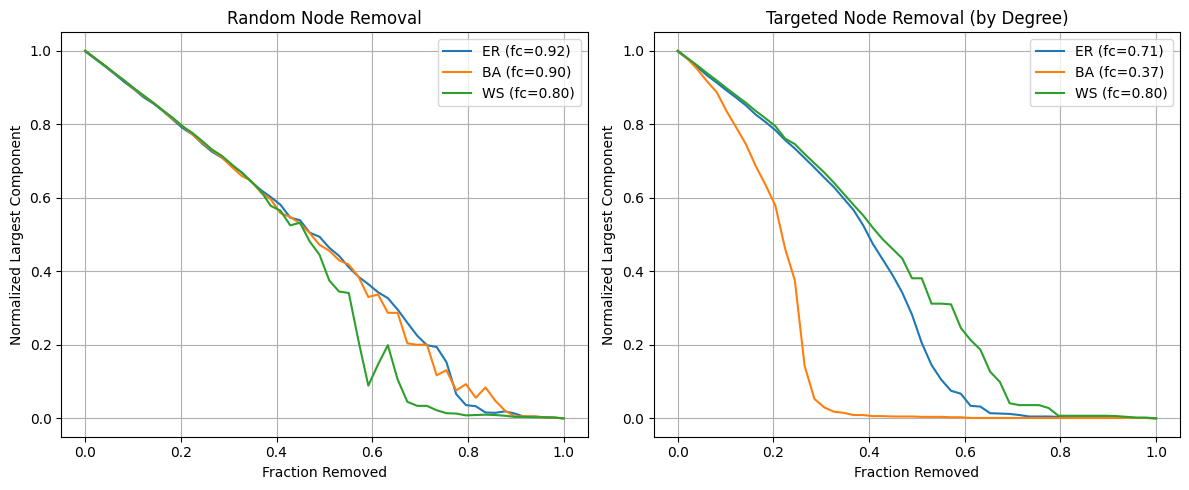

In [ ]:
#2 Robustness In Complex NW
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: Generate Networks
# Task: Create ER, BA, and WS networks for comparison.
# Why: Different topologies show varying robustness.
def generate_networks(n=1000, p_er=0.006, m_ba=3, k_ws=6, p_ws=0.1):
    """
    Generate three types of networks:
    - Erdős-Rényi (ER): Random graph.
    - Barabási-Albert (BA): Scale-free.
    - Watts-Strogatz (WS): Small-world.

    Parameters chosen for similar average degree ~6.
    """
    ER = nx.erdos_renyi_graph(n, p_er)
    BA = nx.barabasi_albert_graph(n, m_ba)
    WS = nx.watts_strogatz_graph(n, k_ws, p_ws)
    return ER, BA, WS

# Exercise 2: Percolation Simulation
# Task: Simulate node removal (random or targeted) and track largest connected component.
# Why: Measures robustness; failure threshold is where giant component vanishes.
def percolation_simulation(G, removal_type='random', steps=50):
    """
    Simulate percolation by removing nodes fractionally.

    Parameters:
    - removal_type: 'random' or 'targeted' (by degree).
    - steps: Number of fractions to test (e.g., 0 to 1 in steps).

    Returns: fractions_removed, largest_component_sizes (normalized by N).
    """
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []

    for f in fractions:
        G_copy = G.copy()
        if removal_type == 'targeted':
            # Sort nodes by degree descending
            nodes_sorted = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node[0] for node in nodes_sorted[:int(f * N)]]
        else:
            # Random removal
            nodes_to_remove = list(G_copy.nodes())
            np.random.shuffle(nodes_to_remove)
            nodes_to_remove = nodes_to_remove[:int(f * N)]

        G_copy.remove_nodes_from(nodes_to_remove)
        if len(G_copy) == 0:
            largest = 0
        else:
            components = nx.connected_components(G_copy)
            largest = max(len(c) for c in components) / N
        largest_components.append(largest)

    return fractions, largest_components

# Exercise 3: Find Failure Threshold
# Task: Estimate percolation threshold (fc) where largest component drops below a threshold (e.g., sqrt(N)/N).
# Why: fc indicates critical point of network fragmentation.
# Extension: For ER, theoretical fc = 1 - 1/<k>, where <k> is avg degree.
def find_failure_threshold(fractions, largest_components, threshold=0.01):
    """
    Find the smallest fraction where largest component <= threshold.

    Returns: fc (failure threshold).
    """
    for i, size in enumerate(largest_components):
        if size <= threshold:
            return fractions[i]
    return 1.0  # If never reaches threshold

# Exercise 4: Plot Results
# Task: Visualize percolation curves for random vs. targeted on different networks.
# Why: Highlights scale-free networks' vulnerability to attacks.
def plot_percolation(ER, BA, WS):
    """
    Run simulations and plot for all networks.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for net_name, G in zip(['ER', 'BA', 'WS'], [ER, BA, WS]):
        # Random removal
        fr_rand, lc_rand = percolation_simulation(G, 'random')
        fc_rand = find_failure_threshold(fr_rand, lc_rand)
        axs[0].plot(fr_rand, lc_rand, label=f'{net_name} (fc={fc_rand:.2f})')

        # Targeted removal
        fr_targ, lc_targ = percolation_simulation(G, 'targeted')
        fc_targ = find_failure_threshold(fr_targ, lc_targ)
        axs[1].plot(fr_targ, lc_targ, label=f'{net_name} (fc={fc_targ:.2f})')

    axs[0].set_title('Random Node Removal')
    axs[0].set_xlabel('Fraction Removed')
    axs[0].set_ylabel('Normalized Largest Component')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title('Targeted Node Removal (by Degree)')
    axs[1].set_xlabel('Fraction Removed')
    axs[1].set_ylabel('Normalized Largest Component')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Exercise 5: Advanced Analysis - Compare Theoretical vs. Simulated for ER
# Task: For ER, compute theoretical percolation threshold and compare.
# Why: Validates simulation; for ER, fc ≈ 1 - 1/<k>.
def er_theoretical_threshold(G):
    avg_degree = np.mean([d for n, d in G.degree()])
    return 1 - 1 / avg_degree if avg_degree > 1 else 0

# Run All Exercises
if __name__ == "__main__":
    print("=== Robustness Exercises in Complex Networks ===")

    # Exercise 1: Generate networks
    ER, BA, WS = generate_networks()
    print("Networks generated: ER, BA, WS")

    # Exercise 2 & 3: Simulate and find thresholds (example for BA random)
    fr, lc = percolation_simulation(BA, 'random')
    fc = find_failure_threshold(fr, lc)
    print(f"BA Random Failure Threshold: {fc:.2f}")

    # For ER theoretical
    fc_theory = er_theoretical_threshold(ER)
    print(f"ER Theoretical Random Threshold: {fc_theory:.2f}")

    # Exercise 4: Plot all
    plot_percolation(ER, BA, WS)

    # Exercise 5: Additional tasks (e.g., vary parameters)
    # Task: Rerun with n=5000, compare fc stability.
    # Question: How does targeted attack affect BA vs. ER?
    # Interpretation: BA has lower fc for targeted (vulnerable hubs), higher for random (robust).

# Additional Lab Exercises Ideas:
# 1. Edge percolation: Remove edges instead of nodes.
# 2. Cascading failures: Simulate with load redistribution.
# 3. Multiple runs: Average over 10 networks for error bars.
# 4. Other networks: Add configuration model for custom degree sequences.
# 5. Metrics: Track clustering or path length during percolation.

=== BA and ER Network Robustness and Scale-Free Property Analysis ===
xmin progress: 85%
BA Original Network Metrics:
avg_path_length: 3.472
diameter: 6
avg_clustering: 0.025
assortativity: -0.089
min_degree: 3
max_degree: 101
avg_degree: 5.982
Power-law vs Exponential: R=50.409, p=0.000

BA After 20% Random Node Removal:
avg_path_length: inf
diameter: inf
avg_clustering: 0.027
assortativity: -0.091
min_degree: 0
max_degree: 82
avg_degree: 4.935
Power-law vs Exponential: R=28.469, p=0.000

BA After 20% Targeted Node Removal:
avg_path_length: inf
diameter: inf
avg_clustering: 0.004
assortativity: -0.061
min_degree: 0
max_degree: 6
avg_degree: 1.685
Power-law vs Exponential: R=1.301, p=0.000

ER Original Network Metrics:
avg_path_length: inf
diameter: inf
avg_clustering: 0.006
assortativity: -0.003
min_degree: 0
max_degree: 17
avg_degree: 5.918
Power-law vs Exponential: R=4.044, p=0.001

ER After 20% Random Node Removal:
avg_path_length: inf
diameter: inf
avg_clustering: 0.006
assortativ

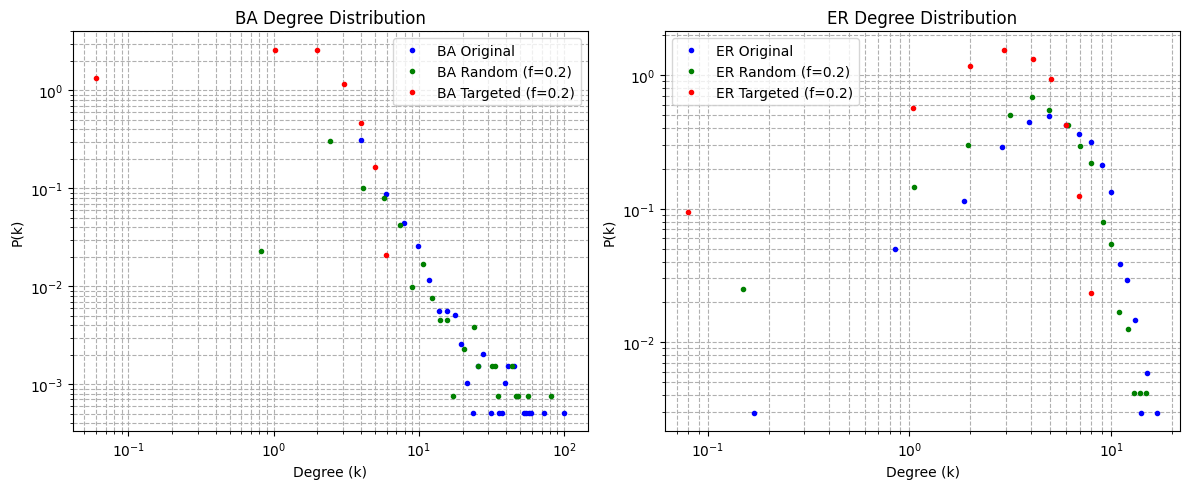

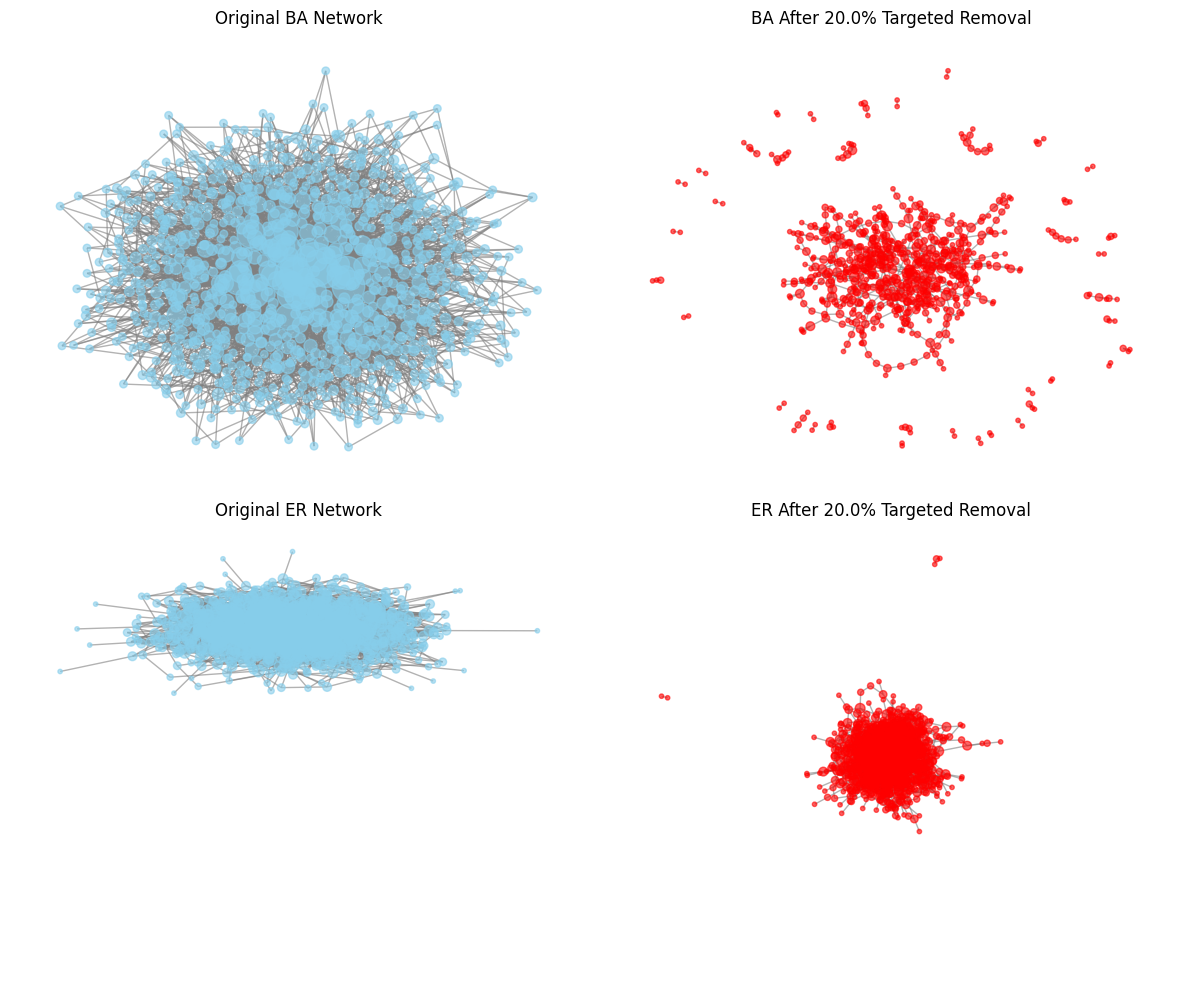

In [ ]:
# Continuation of How the removal of nodes affect the degree distribution anf Scale Free Check after Removal
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from powerlaw import Fit

# Function to compute metrics and degree distribution with power-law validation
def compute_metrics_and_distribution(G, label="Original"):
    """
    Compute network metrics and degree distribution with power-law fit validation.
    Returns metrics dict and (hist, bin_centers, fit, power_law_stats).
    """
    metrics = {}
    if nx.is_connected(G):
        metrics['avg_path_length'] = nx.average_shortest_path_length(G)
        metrics['diameter'] = nx.diameter(G)
    else:
        metrics['avg_path_length'] = float('inf')  # Disconnected network
        metrics['diameter'] = float('inf')
    metrics['avg_clustering'] = nx.average_clustering(G)
    metrics['assortativity'] = nx.degree_assortativity_coefficient(G)
    degrees = [d for n, d in G.degree()]
    metrics['min_degree'] = min(degrees) if degrees else 0
    metrics['max_degree'] = max(degrees) if degrees else 0
    metrics['avg_degree'] = np.mean(degrees) if degrees else 0

    # Degree distribution
    hist, bin_edges = np.histogram(degrees, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    valid = hist > 0  # For log-log plot

    # Power-law fit and validation
    power_law_stats = {}
    fit = Fit(degrees, verbose=False) if degrees else None
    power_law_stats['alpha'] = fit.power_law.alpha if fit else 0
    power_law_stats['xmin'] = fit.power_law.xmin if fit else 0
    # Compare power-law to exponential distribution
    if fit:
        R, p = fit.distribution_compare('power_law', 'exponential')
        power_law_stats['vs_exponential_R'] = R  # Positive R favors power-law
        power_law_stats['vs_exponential_p'] = p   # p < 0.05 suggests significant difference
    else:
        power_law_stats['vs_exponential_R'] = 0
        power_law_stats['vs_exponential_p'] = 1

    return metrics, (hist[valid], bin_centers[valid], fit, power_law_stats)

# Function for node removal
def remove_nodes(G, fraction, removal_type='random'):
    """
    Remove a fraction of nodes (random or targeted by degree).
    Returns modified graph.
    """
    G_copy = G.copy()
    N = len(G_copy)
    num_remove = int(fraction * N)
    if removal_type == 'targeted':
        nodes_to_remove = sorted(G_copy.degree, key=lambda x: x[1], reverse=True)
        nodes_to_remove = [node[0] for node in nodes_to_remove[:num_remove]]
    else:
        nodes_to_remove = list(G_copy.nodes())
        np.random.shuffle(nodes_to_remove)
        nodes_to_remove = nodes_to_remove[:num_remove]
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy

# Main analysis
if __name__ == "__main__":
    print("=== BA and ER Network Robustness and Scale-Free Property Analysis ===")

    # Network parameters
    n = 1000  # Number of nodes
    m = 3     # Edges per new node for BA
    p_er = 2 * m / (n - 1)  # ER probability to match BA avg degree ~6
    fraction = 0.2  # Fraction of nodes to remove

    # Generate networks
    BA = nx.barabasi_albert_graph(n, m)
    ER = nx.erdos_renyi_graph(n, p_er)

    # Analyze BA network
    ba_orig_metrics, (ba_orig_hist, ba_orig_bins, ba_orig_fit, ba_orig_pl_stats) = compute_metrics_and_distribution(BA, "BA Original")
    ba_random = remove_nodes(BA, fraction, 'random')
    ba_rand_metrics, (ba_rand_hist, ba_rand_bins, ba_rand_fit, ba_rand_pl_stats) = compute_metrics_and_distribution(ba_random, "BA Random Removal")
    ba_targeted = remove_nodes(BA, fraction, 'targeted')
    ba_targ_metrics, (ba_targ_hist, ba_targ_bins, ba_targ_fit, ba_targ_pl_stats) = compute_metrics_and_distribution(ba_targeted, "BA Targeted Removal")

    # Analyze ER network
    er_orig_metrics, (er_orig_hist, er_orig_bins, er_orig_fit, er_orig_pl_stats) = compute_metrics_and_distribution(ER, "ER Original")
    er_random = remove_nodes(ER, fraction, 'random')
    er_rand_metrics, (er_rand_hist, er_rand_bins, er_rand_fit, er_rand_pl_stats) = compute_metrics_and_distribution(er_random, "ER Random Removal")
    er_targeted = remove_nodes(ER, fraction, 'targeted')
    er_targ_metrics, (er_targ_hist, er_targ_bins, er_targ_fit, er_targ_pl_stats) = compute_metrics_and_distribution(er_targeted, "ER Targeted Removal")

    # Print results
    print("\nBA Original Network Metrics:")
    for key, value in ba_orig_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={ba_orig_pl_stats['vs_exponential_R']:.3f}, p={ba_orig_pl_stats['vs_exponential_p']:.3f}")

    print("\nBA After 20% Random Node Removal:")
    for key, value in ba_rand_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={ba_rand_pl_stats['vs_exponential_R']:.3f}, p={ba_rand_pl_stats['vs_exponential_p']:.3f}")

    print("\nBA After 20% Targeted Node Removal:")
    for key, value in ba_targ_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={ba_targ_pl_stats['vs_exponential_R']:.3f}, p={ba_targ_pl_stats['vs_exponential_p']:.3f}")

    print("\nER Original Network Metrics:")
    for key, value in er_orig_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={er_orig_pl_stats['vs_exponential_R']:.3f}, p={er_orig_pl_stats['vs_exponential_p']:.3f}")

    print("\nER After 20% Random Node Removal:")
    for key, value in er_rand_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={er_rand_pl_stats['vs_exponential_R']:.3f}, p={er_rand_pl_stats['vs_exponential_p']:.3f}")

    print("\nER After 20% Targeted Node Removal:")
    for key, value in er_targ_metrics.items():
        print(f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}")
    print(f"Power-law vs Exponential: R={er_targ_pl_stats['vs_exponential_R']:.3f}, p={er_targ_pl_stats['vs_exponential_p']:.3f}")

    # Plot degree distributions
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.loglog(ba_orig_bins, ba_orig_hist, 'b.', label='BA Original')
    plt.loglog(ba_rand_bins, ba_rand_hist, 'g.', label=f'BA Random (f={fraction})')
    plt.loglog(ba_targ_bins, ba_targ_hist, 'r.', label=f'BA Targeted (f={fraction})')
    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    plt.title('BA Degree Distribution')
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.subplot(1, 2, 2)
    plt.loglog(er_orig_bins, er_orig_hist, 'b.', label='ER Original')
    plt.loglog(er_rand_bins, er_rand_hist, 'g.', label=f'ER Random (f={fraction})')
    plt.loglog(er_targ_bins, er_targ_hist, 'r.', label=f'ER Targeted (f={fraction})')
    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    plt.title('ER Degree Distribution')
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.tight_layout()
    plt.show()

    # Plot network visualizations
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    pos = nx.spring_layout(BA)
    node_sizes = [d * 10 for n, d in BA.degree()]
    nx.draw(BA, pos, node_size=node_sizes, node_color='skyblue', edge_color='gray', alpha=0.6)
    plt.title('Original BA Network')

    plt.subplot(2, 2, 2)
    pos_targeted = nx.spring_layout(ba_targeted)
    node_sizes_targeted = [d * 10 for n, d in ba_targeted.degree()]
    nx.draw(ba_targeted, pos_targeted, node_size=node_sizes_targeted, node_color='red', edge_color='gray', alpha=0.6)
    plt.title(f'BA After {fraction*100}% Targeted Removal')

    plt.subplot(2, 2, 3)
    pos_er = nx.spring_layout(ER)
    node_sizes_er = [d * 10 for n, d in ER.degree()]
    nx.draw(ER, pos_er, node_size=node_sizes_er, node_color='skyblue', edge_color='gray', alpha=0.6)
    plt.title('Original ER Network')

    plt.subplot(2, 2, 4)
    pos_er_targeted = nx.spring_layout(er_targeted)
    node_sizes_er_targeted = [d * 10 for n, d in er_targeted.degree()]
    nx.draw(er_targeted, pos_er_targeted, node_size=node_sizes_er_targeted, node_color='red', edge_color='gray', alpha=0.6)
    plt.title(f'ER After {fraction*100}% Targeted Removal')

    plt.tight_layout()
    plt.show()


##The ABove can be done using networkx robustness as well

In [ ]:
!pip install networkx-robustness

In [ ]:
import networkx as nx
from networkx_robustness import networkx_robustness as netrob
import matplotlib.pyplot as plt

In [ ]:
# Install the package (run this in a Jupyter/IPython cell; skip if already installed)
# !pip install networkx-robustness

import networkx as nx
import networkx_robustness as rb  # The robustness package
import matplotlib.pyplot as plt
import numpy as np

# Parameters (adjust for your experiments)
N = 500  # Number of nodes
# BA: m = number of edges to attach from new node
# ER: p = probability of edge creation
# WS: k = each node connects to k nearest, p = rewiring prob

# Generate graphs
G_ba = nx.barabasi_albert_graph(N, m=3)
G_er = nx.erdos_renyi_graph(N, p=0.02)  # Approx average degree ~ N*p = 10
G_ws = nx.watts_strogatz_graph(N, k=10, p=0.1)  # Average degree 2*k=20

graphs = {
    'BA (Scale-Free)': G_ba,
    'ER (Random)': G_er,
    'WS (Small-World)': G_ws
}

# Simulate robustness for random failures (kind='random')
# Returns fractions removed and corresponding giant component sizes
fig, ax = plt.subplots(figsize=(10, 6))

for label, G in graphs.items():
    frac_removed, giant_comp_frac = rb.robustness_attack(G, kind='random', percent=100)
    ax.plot(frac_removed, giant_comp_frac, marker='o', label=label, linewidth=2)

ax.set_xlabel('Fraction of Nodes Removed')
ax.set_ylabel('Fraction in Largest Connected Component')
ax.set_title('Network Robustness to Random Node Failures')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Print percolation threshold (approx where giant_comp_frac drops below 0.5)
for label, G in graphs.items():
    frac_removed, giant_comp_frac = rb.robustness_attack(G, kind='random', percent=100)
    threshold_idx = np.where(giant_comp_frac < 0.5)[0]
    threshold = frac_removed[threshold_idx[0]] if len(threshold_idx) > 0 else 1.0
    print(f"{label} Percolation Threshold (random failures): {threshold:.2f}")

AttributeError: module 'networkx_robustness' has no attribute 'simulate_random_attack'

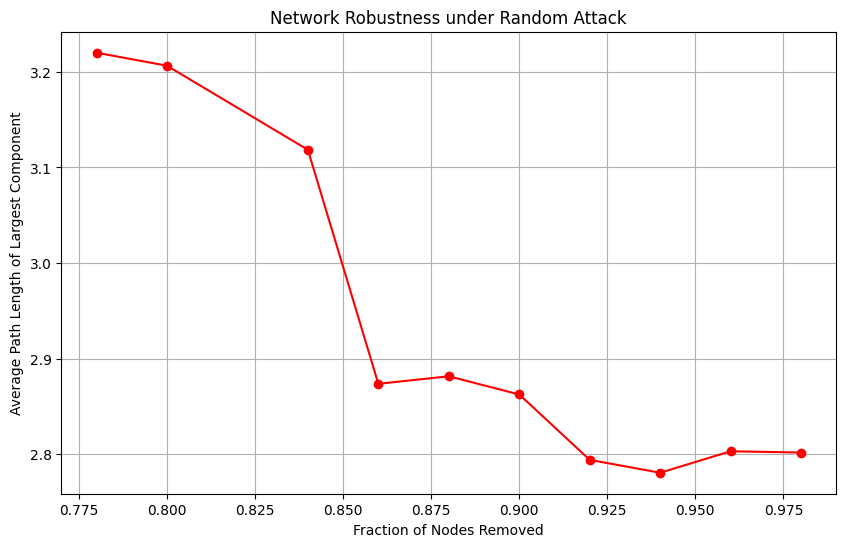

In [ ]:
G = nx.barabasi_albert_graph(50, 2)
initial, frac, apl = netrob.simulate_random_attack(G, attack_fraction=0.2)

plt.figure(figsize=(10, 6))
plt.plot(frac, apl, marker='o', linestyle='-', color='red')
plt.title('Network Robustness under Random Attack')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Path Length of Largest Component')
plt.grid(True)
plt.show()

In [ ]:
molloy_reed = netrob.molloy_reed(G)
molloy_reed

5.458333333333334

In [ ]:
critical_threshold = netrob.critical_threshold(G)
print(critical_threshold)

None


Task

Compare the robustness of the graph G under random, degree, betweenness, closeness, and eigenvector attacks by plotting the average path length against the fraction of nodes removed for each attack type.
Simulate attacks and collect data
Subtask:

Run simulations for random, degree, betweenness, closeness, and eigenvector attacks on the graph G. Store the frac (fraction of nodes removed) and apl (average path length) results for each attack type.

Reasoning: Simulate each type of attack and store the results as instructed.


In [ ]:
initial, frac_random, apl_random = netrob.simulate_random_attack(G, attack_fraction=0.2)
initial, frac_degree, apl_degree = netrob.simulate_degree_attack(G, attack_fraction=0.1, weight=None)
initial, frac_betweenness, apl_betweenness = netrob.simulate_betweenness_attack(G, attack_fraction=0.1, weight=None, normalized=True, k=None, seed=None, endpoints=False)
initial, frac_closeness, apl_closeness = netrob.simulate_closeness_attack(G, attack_fraction=0.1, weight=None, u=None, wf_improved=True)
initial, frac_eigenvector, apl_eigenvector = netrob.simulate_eigenvector_attack(G, attack_fraction=0.1, weight=None, tol=1e-06, max_iter=100, nstart=None)

Plot robustness curves
Subtask:

On a single plot, visualize the apl vs. frac for each attack type. This will allow for a direct comparison of how each attack affects the network's average path length as more nodes are removed.

Reasoning: Plot the average path length against the fraction of nodes removed for each attack type on a single plot for comparison

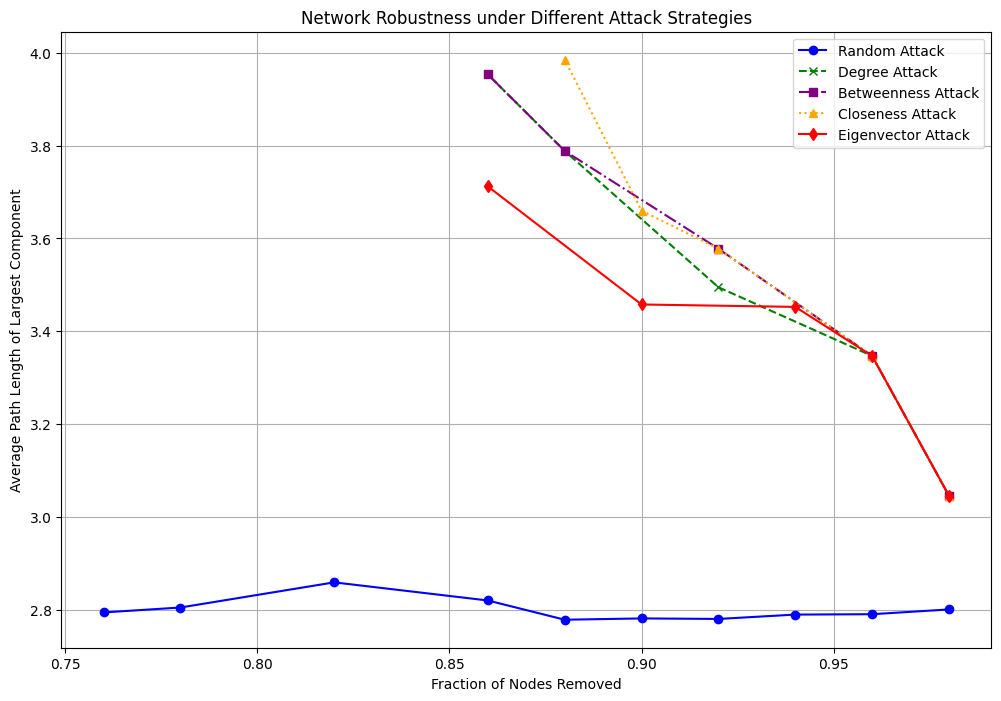

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(frac_random, apl_random, marker='o', linestyle='-', color='blue', label='Random Attack')
plt.plot(frac_degree, apl_degree, marker='x', linestyle='--', color='green', label='Degree Attack')
plt.plot(frac_betweenness, apl_betweenness, marker='s', linestyle='-.', color='purple', label='Betweenness Attack')
plt.plot(frac_closeness, apl_closeness, marker='^', linestyle=':', color='orange', label='Closeness Attack')
plt.plot(frac_eigenvector, apl_eigenvector, marker='d', linestyle='-', color='red', label='Eigenvector Attack')

plt.title('Network Robustness under Different Attack Strategies')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Path Length of Largest Component')
plt.grid(True)
plt.legend()
plt.show()

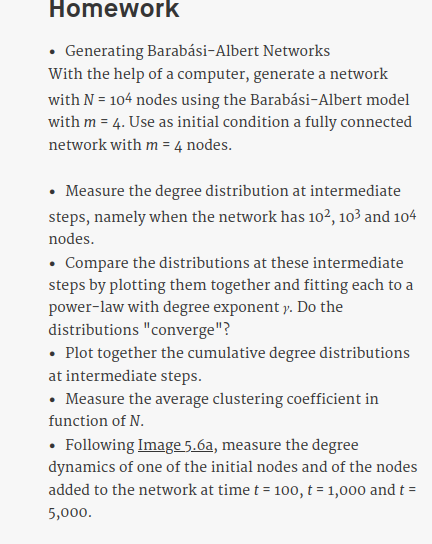

At N=100, power-law exponent γ = 2.610
At N=1000, power-law exponent γ = 2.656
At N=10000, power-law exponent γ = 2.726


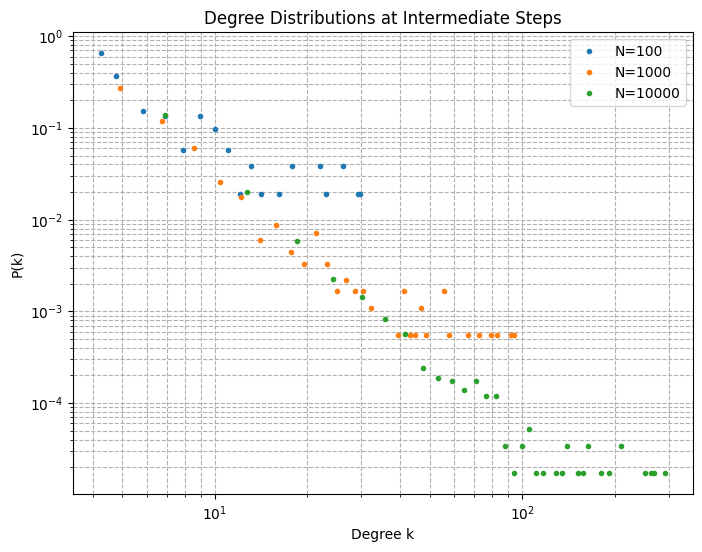

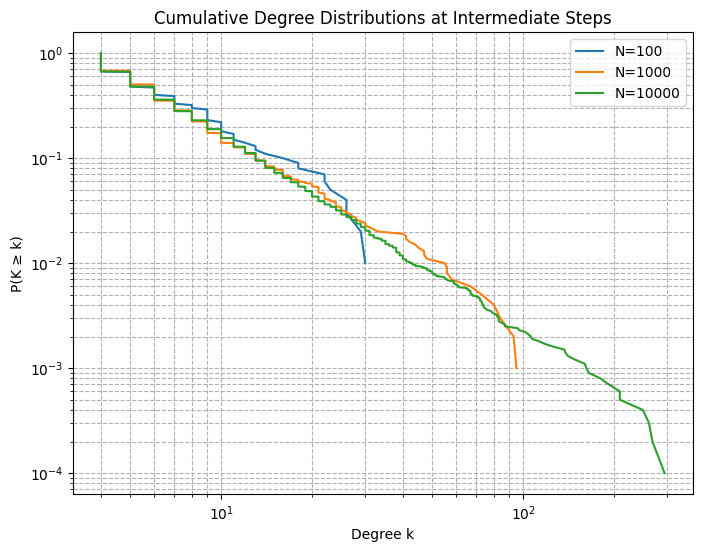

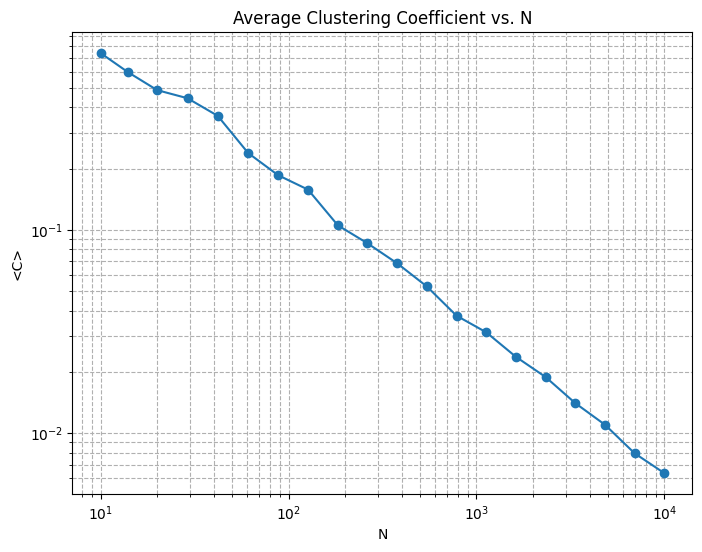

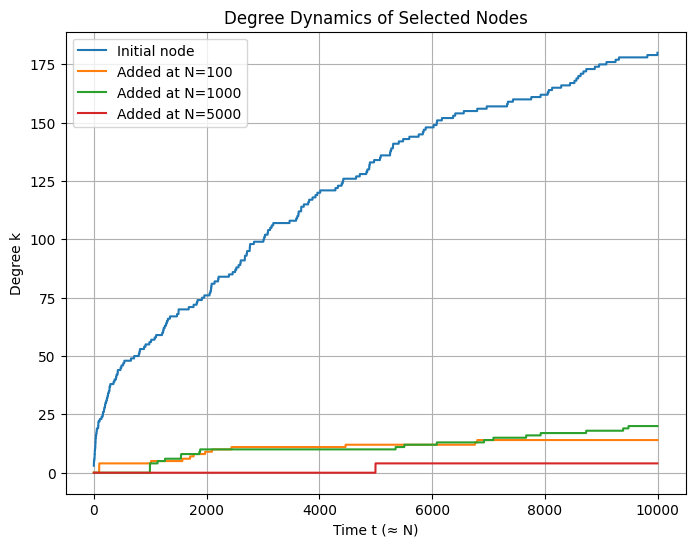

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from powerlaw import Fit

# Parameters
N = 10000  # Final number of nodes
m = 4      # Edges per new node
N_points = [100, 1000, N]  # Intermediate points for degree distribution
tracked_nodes = {0: 'Initial node', 99: 'Added at N=100', 999: 'Added at N=1000', 4999: 'Added at N=5000'}
degree_history = {node: [] for node in tracked_nodes}

# Initialize fully connected network with 4 nodes
G = nx.complete_graph(4)

# Record initial degrees for tracked nodes present
for node in tracked_nodes:
    if node in G:
        degree_history[node].append(G.degree(node))

# Lists for clustering vs N (compute at log-spaced points to speed up)
clustering_points = np.unique(np.logspace(np.log10(10), np.log10(N), num=20, dtype=int))
clustering_values = []
current_N_list = []

# Degree distributions at intermediate N
distributions = {}
fits = {}

# Build the network
for t in range(4, N):
    # Add new node t
    G.add_node(t)

    # Preferential attachment: choose m unique targets with prob ~ degree
    degrees = np.array([G.degree(u) for u in G.nodes()])
    probs = degrees / degrees.sum()
    targets = np.random.choice(list(G.nodes())[:-1], size=m, replace=False, p=probs[:-1]/probs[:-1].sum())  # Exclude self
    for target in targets:
        G.add_edge(t, target)

    # Track degrees
    for node in tracked_nodes:
        if node in G:
            degree_history[node].append(G.degree(node))
        else:
            # If node not added yet, append 0 (pre-addition)
            degree_history[node].append(0)

    current_N = len(G)

    # Compute clustering at specified points
    if current_N in clustering_points:
        clustering_values.append(nx.average_clustering(G))
        current_N_list.append(current_N)

    # Compute degree distribution at intermediate points
    if current_N in N_points:
        degrees = [d for n, d in G.degree()]
        distributions[current_N] = degrees
        fit = Fit(degrees, discrete=True, verbose=False)
        fits[current_N] = fit
        print(f"At N={current_N}, power-law exponent γ = {fit.power_law.alpha:.3f}")

# Final clustering
if N not in current_N_list:
    clustering_values.append(nx.average_clustering(G))
    current_N_list.append(N)

# Plot degree distributions
plt.figure(figsize=(8, 6))
for n_val, degrees in distributions.items():
    hist, bins = np.histogram(degrees, bins=50, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    valid = hist > 0
    plt.loglog(bin_centers[valid], hist[valid], '.', label=f'N={n_val}')
plt.xlabel('Degree k')
plt.ylabel('P(k)')
plt.title('Degree Distributions at Intermediate Steps')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

# Assess convergence: As N increases, the distributions should stabilize to a power-law with γ ≈ 3. If the plots overlay more closely in the tail for larger N, they "converge."

# Plot cumulative degree distributions
plt.figure(figsize=(8, 6))
for n_val, degrees in distributions.items():
    sorted_deg = np.sort(degrees)[::-1]
    cdf = np.arange(1, len(sorted_deg) + 1) / len(sorted_deg)
    plt.loglog(sorted_deg, cdf, '-', label=f'N={n_val}')
plt.xlabel('Degree k')
plt.ylabel('P(K ≥ k)')
plt.title('Cumulative Degree Distributions at Intermediate Steps')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

# Plot average clustering coefficient vs N
plt.figure(figsize=(8, 6))
plt.loglog(current_N_list, clustering_values, 'o-')
plt.xlabel('N')
plt.ylabel('<C>')
plt.title('Average Clustering Coefficient vs. N')
plt.grid(True, which='both', ls='--')
plt.show()

# Plot degree dynamics
plt.figure(figsize=(8, 6))
time_steps = np.arange(1, N + 1)  # Time t ≈ N
for node, label in tracked_nodes.items():
    plt.plot(time_steps[:len(degree_history[node])], degree_history[node], label=label)
plt.xlabel('Time t (≈ N)')
plt.ylabel('Degree k')
plt.title('Degree Dynamics of Selected Nodes')
plt.legend()
plt.grid(True)
plt.show()

![image.png](attachment:image.png)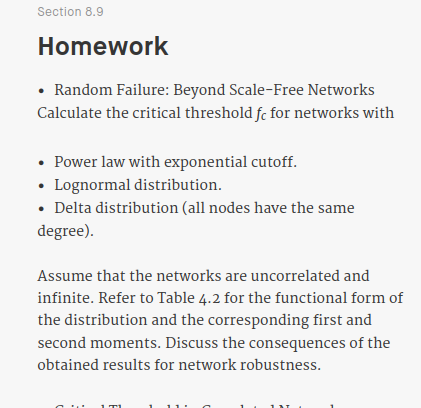

=== Critical Thresholds for Random Failure ===

Power-law with Exponential Cutoff:
Theoretical fc: 0.926, Empirical fc: 0.918
<k>: 7.57, <k^2>: 110.31, kappa: 14.57

Lognormal:
Theoretical fc: 0.918, Empirical fc: 0.878
<k>: 5.83, <k^2>: 77.07, kappa: 13.23

Delta (k0=4):
Theoretical fc: 0.667, Empirical fc: 0.714
<k>: 4.00, <k^2>: 16.00, kappa: 4.00


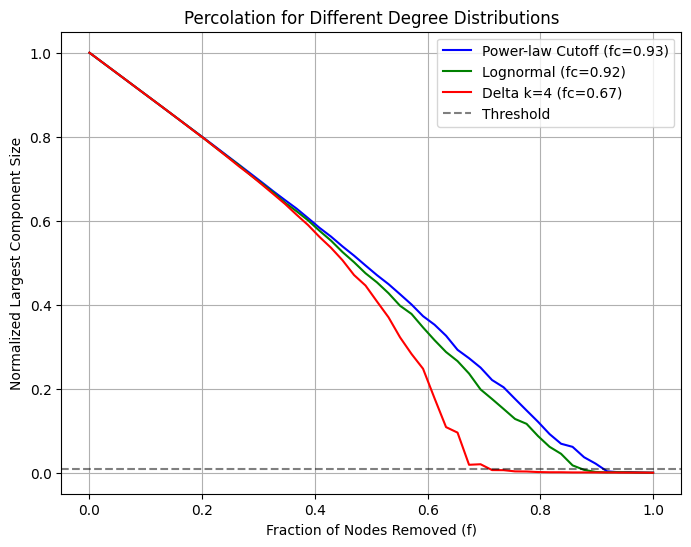

In [ ]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import zeta

# Parameters
N = 10000  # Number of nodes
min_degree = 4  # Minimum degree for power-law with cutoff
gamma = 2.5  # Power-law exponent
lambda_ = 50  # Exponential cutoff parameter
mu = 1  # Lognormal mean (log scale)
sigma = 1  # Lognormal std (log scale)
k0 = 4  # Degree for delta distribution

# Function to generate degree sequence for power-law with exponential cutoff
def generate_powerlaw_cutoff(N, gamma, lambda_, min_degree):
    """Generate degree sequence from P(k) ~ k^-gamma * exp(-k/lambda)."""
    max_degree = int(min_degree * 100)  # Cap for practicality
    k = np.arange(min_degree, max_degree + 1)
    probs = k**(-gamma) * np.exp(-k/lambda_)
    probs /= probs.sum()
    degrees = np.random.choice(k, size=N, p=probs)
    if sum(degrees) % 2 != 0:  # Ensure sum is even for valid graph
        degrees[-1] += 1
    return degrees

# Function to generate lognormal degree sequence
def generate_lognormal(N, mu, sigma, min_degree):
    """Generate degree sequence from lognormal distribution."""
    degrees = np.random.lognormal(mu, sigma, N).astype(int)
    degrees = np.maximum(degrees, min_degree)  # Enforce min degree
    max_degree = int(min_degree * 100)
    degrees = np.minimum(degrees, max_degree)  # Cap for practicality
    if sum(degrees) % 2 != 0:
        degrees[-1] += 1
    return degrees

# Function to compute moments and theoretical fc
def compute_theoretical_fc(degrees, distribution_type, params=None):
    """Compute <k>, <k^2>, and theoretical fc."""
    degrees = np.array(degrees)  # Convert to NumPy array
    k_mean = np.mean(degrees)
    k2_mean = np.mean(degrees**2)
    kappa = k2_mean / k_mean
    fc = 1 - 1 / (kappa - 1) if kappa > 2 else 0
    return k_mean, k2_mean, fc

# Function to simulate random node removal and find empirical fc
def simulate_percolation(G, steps=50, threshold=0.01):
    """Simulate random node removal and find empirical fc."""
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []
    for f in fractions:
        G_copy = G.copy()
        nodes_to_remove = np.random.choice(list(G_copy.nodes()), size=int(f * N), replace=False)
        G_copy.remove_nodes_from(nodes_to_remove)
        if len(G_copy) == 0:
            largest_components.append(0)
        else:
            components = list(nx.connected_components(G_copy))
            largest_components.append(max(len(c) for c in components) / N)

    # Find empirical fc where largest component < threshold
    for i, size in enumerate(largest_components):
        if size <= threshold:
            return fractions[i], fractions, largest_components
    return 1.0, fractions, largest_components

# Generate networks
# 1. Power-law with exponential cutoff
pl_degrees = generate_powerlaw_cutoff(N, gamma, lambda_, min_degree)
G_pl = nx.configuration_model(pl_degrees, create_using=nx.Graph)
G_pl = nx.Graph(G_pl)  # Remove multi-edges/self-loops

# 2. Lognormal
ln_degrees = generate_lognormal(N, mu, sigma, min_degree)
G_ln = nx.configuration_model(ln_degrees, create_using=nx.Graph)
G_ln = nx.Graph(G_ln)

# 3. Delta (k-regular graph)
G_delta = nx.random_regular_graph(k0, N)

# Compute theoretical fc
pl_k_mean, pl_k2_mean, pl_fc = compute_theoretical_fc(pl_degrees, 'powerlaw_cutoff')
ln_k_mean, ln_k2_mean, ln_fc = compute_theoretical_fc(ln_degrees, 'lognormal')
delta_k_mean, delta_k2_mean, delta_fc = compute_theoretical_fc([k0] * N, 'delta')

# Simulate empirical fc
pl_fc_emp, pl_fracs, pl_sizes = simulate_percolation(G_pl)
ln_fc_emp, ln_fracs, ln_sizes = simulate_percolation(G_ln)
delta_fc_emp, delta_fracs, delta_sizes = simulate_percolation(G_delta)

# Print results
print("=== Critical Thresholds for Random Failure ===")
print("\nPower-law with Exponential Cutoff:")
print(f"Theoretical fc: {pl_fc:.3f}, Empirical fc: {pl_fc_emp:.3f}")
print(f"<k>: {pl_k_mean:.2f}, <k^2>: {pl_k2_mean:.2f}, kappa: {pl_k2_mean/pl_k_mean:.2f}")

print("\nLognormal:")
print(f"Theoretical fc: {ln_fc:.3f}, Empirical fc: {ln_fc_emp:.3f}")
print(f"<k>: {ln_k_mean:.2f}, <k^2>: {ln_k2_mean:.2f}, kappa: {ln_k2_mean/ln_k_mean:.2f}")

print("\nDelta (k0=4):")
print(f"Theoretical fc: {delta_fc:.3f}, Empirical fc: {delta_fc_emp:.3f}")
print(f"<k>: {delta_k_mean:.2f}, <k^2>: {delta_k2_mean:.2f}, kappa: {delta_k2_mean/delta_k_mean:.2f}")

# Plot percolation curves
plt.figure(figsize=(8, 6))
plt.plot(pl_fracs, pl_sizes, 'b-', label=f'Power-law Cutoff (fc={pl_fc:.2f})')
plt.plot(ln_fracs, ln_sizes, 'g-', label=f'Lognormal (fc={ln_fc:.2f})')
plt.plot(delta_fracs, delta_sizes, 'r-', label=f'Delta k={k0} (fc={delta_fc:.2f})')
plt.axhline(y=0.01, color='k', linestyle='--', alpha=0.5, label='Threshold')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('Normalized Largest Component Size')
plt.title('Percolation for Different Degree Distributions')
plt.legend()
plt.grid(True)
plt.show()


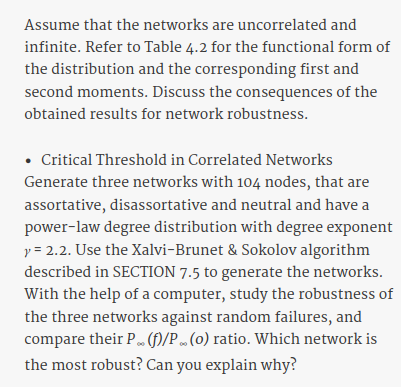

In [ ]:
#Running for Alot of time

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 10000  # Number of nodes
gamma = 2.2  # Power-law exponent
k_min = 2  # Minimum degree
rewiring_steps = 100000  # Number of rewiring steps for XB&S algorithm

# Function to generate power-law degree sequence
def generate_powerlaw_degrees(N, gamma, k_min):
    """Generate degree sequence from P(k) ~ k^-gamma."""
    max_degree = int(N**(1/(gamma-1)))  # Finite-size cutoff ~ N^(1/(gamma-1))
    k = np.arange(k_min, max_degree + 1)
    probs = k**(-gamma)
    probs /= probs.sum()
    degrees = np.random.choice(k, size=N, p=probs)
    if sum(degrees) % 2 != 0:  # Ensure sum is even
        degrees[-1] += 1
    return degrees

# Xulvi-Brunet & Sokolov algorithm for assortative/disassortative rewiring
def xbs_rewiring(G, assortative=True, steps=100000):
    """Rewire network to increase (assortative=True) or decrease (assortative=False) assortativity."""
    G_copy = G.copy()
    for _ in range(steps):
        # Select two random edges
        edges = list(G_copy.edges())
        if len(edges) < 2:
            break
        e1, e2 = np.random.choice(len(edges), size=2, replace=False)
        u, v = edges[e1]
        x, y = edges[e2]
        # Ensure distinct nodes
        if u in (x, y) or v in (x, y):
            continue
        # Degrees
        du, dv, dx, dy = G_copy.degree(u), G_copy.degree(v), G_copy.degree(x), G_copy.degree(y)
        if assortative:
            # Swap to increase assortativity: connect similar-degree pairs
            if abs(du - dy) + abs(dv - dx) < abs(du - dv) + abs(dx - dy):
                G_copy.remove_edges_from([(u, v), (x, y)])
                G_copy.add_edges_from([(u, y), (x, v)])
        else:
            # Swap to decrease assortativity: connect dissimilar-degree pairs
            if abs(du - dx) + abs(dv - dy) < abs(du - dv) + abs(dx - dy):
                G_copy.remove_edges_from([(u, v), (x, y)])
                G_copy.add_edges_from([(u, x), (v, y)])
    return G_copy

# Simulate random node removal
def simulate_percolation(G, steps=20):
    """Simulate random node removal and return f, P_infty(f)/P_infty(0)."""
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []
    for f in fractions:
        G_copy = G.copy()
        nodes_to_remove = np.random.choice(list(G_copy.nodes()), size=int(f * N), replace=False)
        G_copy.remove_nodes_from(nodes_to_remove)
        if len(G_copy) == 0:
            largest_components.append(0)
        else:
            components = list(nx.connected_components(G_copy))
            largest_components.append(max(len(c) for c in components) / N)
    return fractions, largest_components

# Generate degree sequence
degrees = generate_powerlaw_degrees(N, gamma, k_min)

# Create networks
# 1. Neutral (configuration model)
G_neutral = nx.configuration_model(degrees, create_using=nx.Graph)
G_neutral = nx.Graph(G_neutral)  # Remove multi-edges/self-loops

# 2. Assortative
G_assortative = xbs_rewiring(G_neutral, assortative=True, steps=rewiring_steps)

# 3. Disassortative
G_disassortative = xbs_rewiring(G_neutral, assortative=False, steps=rewiring_steps)

# Compute assortativity coefficients
r_neutral = nx.degree_assortativity_coefficient(G_neutral)
r_assortative = nx.degree_assortativity_coefficient(G_assortative)
r_disassortative = nx.degree_assortativity_coefficient(G_disassortative)

# Simulate percolation for each network
fracs_neutral, sizes_neutral = simulate_percolation(G_neutral)
fracs_assort, sizes_assort = simulate_percolation(G_assortative)
fracs_disassort, sizes_disassort = simulate_percolation(G_disassortative)

# Print assortativity
print("=== Assortativity Coefficients ===")
print(f"Neutral: r = {r_neutral:.3f}")
print(f"Assortative: r = {r_assortative:.3f}")
print(f"Disassortative: r = {r_disassortative:.3f}")

# Plot percolation curves
plt.figure(figsize=(8, 6))
plt.plot(fracs_neutral, sizes_neutral, 'b-', label=f'Neutral (r={r_neutral:.2f})')
plt.plot(fracs_assort, sizes_assort, 'g-', label=f'Assortative (r={r_assortative:.2f})')
plt.plot(fracs_disassort, sizes_disassort, 'r-', label=f'Disassortative (r={r_disassortative:.2f})')
plt.xlabel('Fraction of Nodes Removed (f)')
plt.ylabel('P_infty(f) / P_infty(0)')
plt.title('Robustness of Correlated Power-Law Networks (γ=2.2)')
plt.legend()
plt.grid(True)
plt.show()

# Determine critical thresholds empirically (where P_infty drops below 0.01)
def find_empirical_fc(fractions, sizes, threshold=0.01):
    for i, size in enumerate(sizes):
        if size <= threshold:
            return fractions[i]
    return 1.0

fc_neutral = find_empirical_fc(fracs_neutral, sizes_neutral)
fc_assort = find_empirical_fc(fracs_assort, sizes_assort)
fc_disassort = find_empirical_fc(fracs_disassort, sizes_disassort)

print("\n=== Empirical Critical Thresholds ===")
print(f"Neutral: fc = {fc_neutral:.3f}")
print(f"Assortative: fc = {fc_assort:.3f}")
print(f"Disassortative: fc = {fc_disassort:.3f}")


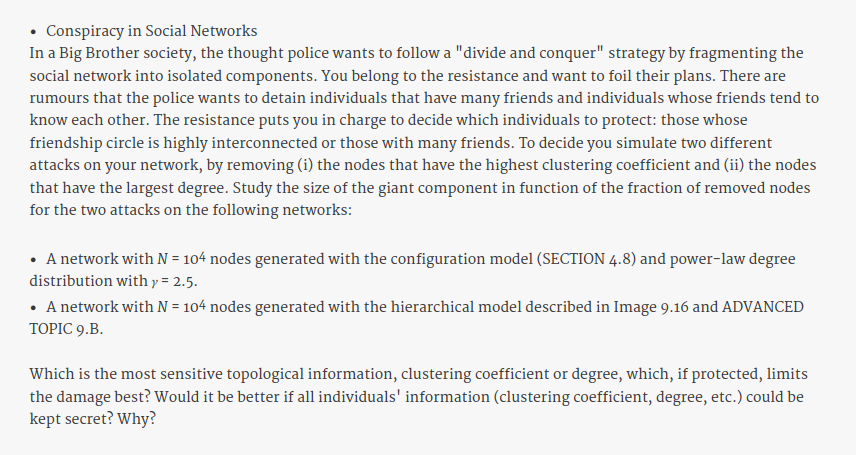

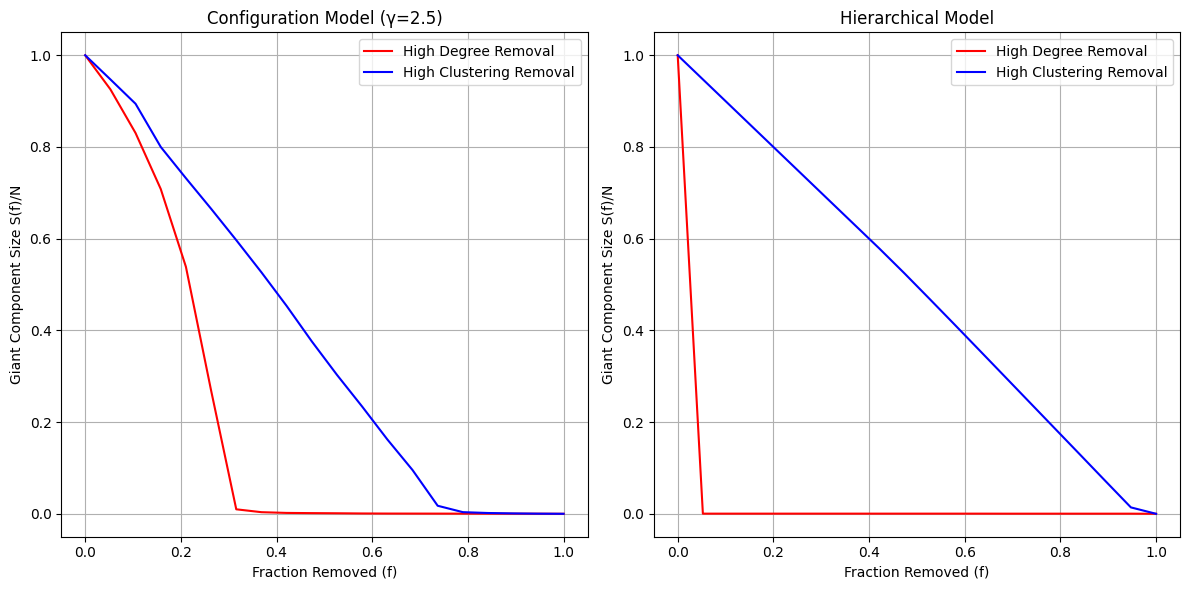

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N_config = 15625  # To match hierarchical N for comparison (5**6 = 15625; close to 10^4)
gamma = 2.5  # Power-law exponent for configuration model
k_min = 3  # Minimum degree to ensure connectivity
steps = 20  # Number of fractions for removal simulation

# Function to generate power-law degree sequence for configuration model
def generate_powerlaw_degrees(N, gamma, k_min):
    max_degree = int(N ** (1 / (gamma - 1)))  # Finite-size cutoff
    k = np.arange(k_min, max_degree + 1)
    probs = k ** (-gamma)
    probs /= probs.sum()
    degrees = np.random.choice(k, size=N, p=probs)
    if sum(degrees) % 2 != 0:
        degrees[-1] += 1
    return degrees

# Function to generate hierarchical network (Ravasz-Barabási model)
def generate_hierarchical(level):
    if level == 1:
        G = nx.complete_graph(5)
        central = 0
        external = [1, 2, 3, 4]
        return G, central, external

    G_prev, central_prev, external_prev = generate_hierarchical(level - 1)
    G = G_prev.copy()
    node_offset = len(G)
    replicas_offsets = []
    new_external = []
    for _ in range(4):
        H = G_prev.copy()
        mapping = {u: u + node_offset for u in H.nodes()}
        H = nx.relabel_nodes(H, mapping)
        G = nx.union(G, H)
        replicas_offsets.append(node_offset)
        rep_external = [e + node_offset for e in external_prev]
        new_external += rep_external
        for ex in rep_external:
            G.add_edge(ex, central_prev)
        node_offset += len(G_prev)
    new_central = central_prev
    return G, new_central, new_external

# Function to simulate targeted removal
def simulate_targeted_removal(G, metric_key, steps=20):
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []
    # Compute metrics
    if metric_key == 'degree':
        metrics = {n: d for n, d in G.degree()}
    elif metric_key == 'clustering':
        metrics = nx.clustering(G)
    # Sort nodes by metric descending
    sorted_nodes = sorted(G.nodes(), key=lambda n: metrics[n], reverse=True)
    for f in fractions:
        num_remove = int(f * N)
        remove_list = sorted_nodes[:num_remove]
        G_copy = G.copy()
        G_copy.remove_nodes_from(remove_list)
        if len(G_copy) == 0:
            largest_components.append(0)
        else:
            components = list(nx.connected_components(G_copy))
            largest_components.append(max(len(c) for c in components) / N)
    return fractions, largest_components

# Generate configuration model network
config_degrees = generate_powerlaw_degrees(N_config, gamma, k_min)
G_config = nx.configuration_model(config_degrees, create_using=nx.Graph)
G_config = nx.Graph(G_config)  # Remove multi-edges/self-loops

# Generate hierarchical network (level 6, N=15625)
G_hier, _, _ = generate_hierarchical(6)

# Simulate attacks on configuration model
config_fracs_deg, config_sizes_deg = simulate_targeted_removal(G_config, 'degree', steps)
config_fracs_clus, config_sizes_clus = simulate_targeted_removal(G_config, 'clustering', steps)

# Simulate attacks on hierarchical network
hier_fracs_deg, hier_sizes_deg = simulate_targeted_removal(G_hier, 'degree', steps)
hier_fracs_clus, hier_sizes_clus = simulate_targeted_removal(G_hier, 'clustering', steps)

# Plot results for configuration model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(config_fracs_deg, config_sizes_deg, 'r-', label='High Degree Removal')
plt.plot(config_fracs_clus, config_sizes_clus, 'b-', label='High Clustering Removal')
plt.xlabel('Fraction Removed (f)')
plt.ylabel('Giant Component Size S(f)/N')
plt.title('Configuration Model (γ=2.5)')
plt.legend()
plt.grid(True)

# Plot results for hierarchical model
plt.subplot(1, 2, 2)
plt.plot(hier_fracs_deg, hier_sizes_deg, 'r-', label='High Degree Removal')
plt.plot(hier_fracs_clus, hier_sizes_clus, 'b-', label='High Clustering Removal')
plt.xlabel('Fraction Removed (f)')
plt.ylabel('Giant Component Size S(f)/N')
plt.title('Hierarchical Model')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Analysis (as comments):
# For both networks, high degree removal (red) reduces the giant component faster than high clustering removal (blue).
# Thus, degree is more sensitive topological information; protecting high-degree individuals limits damage best, as removing them fragments the network

![image.png](attachment:image.png)

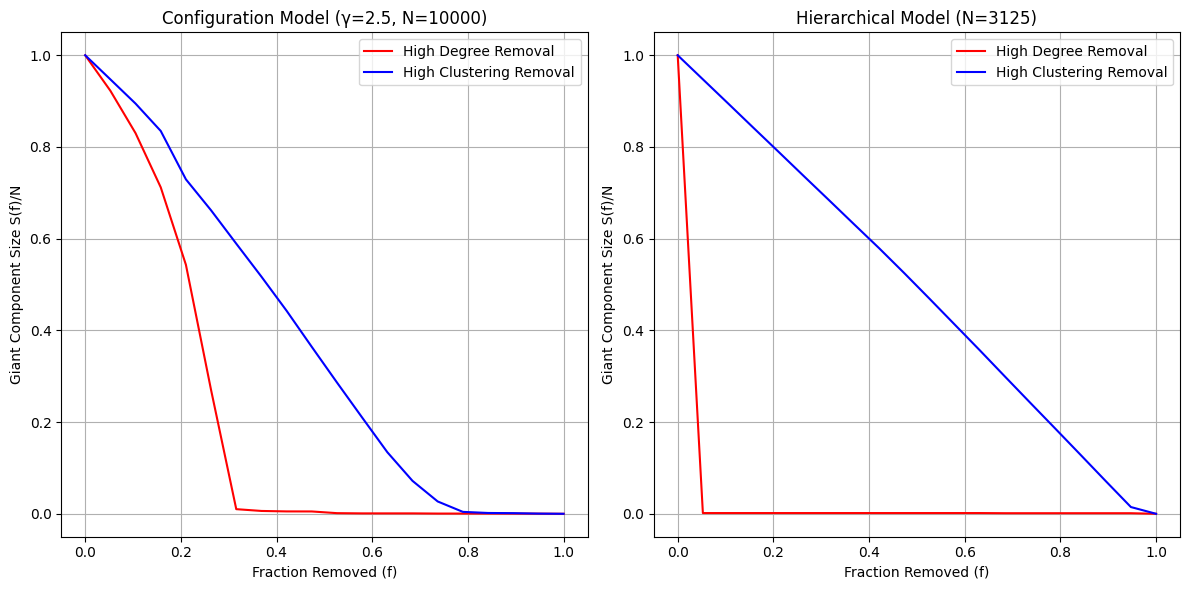

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N_config = 10000  # Number of nodes for configuration model
gamma = 2.5  # Power-law exponent
k_min = 3  # Minimum degree
steps = 20  # Number of fractions for removal simulation

# Function to generate power-law degree sequence for configuration model
def generate_powerlaw_degrees(N, gamma, k_min):
    max_degree = int(N ** (1 / (gamma - 1)))  # Finite-size cutoff
    k = np.arange(k_min, max_degree + 1)
    probs = k ** (-gamma)
    probs /= probs.sum()
    degrees = np.random.choice(k, size=N, p=probs)
    if sum(degrees) % 2 != 0:
        degrees[-1] += 1
    return degrees

# Function to generate hierarchical network (Ravasz-Barabási model, ADVANCED TOPIC 9.B)
def generate_hierarchical(level):
    if level == 1:
        G = nx.complete_graph(5)
        central = 0
        external = [1, 2, 3, 4]
        return G, central, external

    G_prev, central_prev, external_prev = generate_hierarchical(level - 1)
    G = G_prev.copy()
    node_offset = len(G)
    replicas_offsets = []
    new_external = []
    for _ in range(4):
        H = G_prev.copy()
        mapping = {u: u + node_offset for u in H.nodes()}
        H = nx.relabel_nodes(H, mapping)
        G = nx.union(G, H)
        replicas_offsets.append(node_offset)
        rep_external = [e + node_offset for e in external_prev]
        new_external += rep_external
        for ex in rep_external:
            G.add_edge(ex, central_prev)
        node_offset += len(G_prev)
    new_central = central_prev
    return G, new_central, new_external

# Function to simulate targeted removal
def simulate_targeted_removal(G, metric_key, steps=20):
    N = len(G)
    fractions = np.linspace(0, 1, steps)
    largest_components = []
    # Compute metrics
    if metric_key == 'degree':
        metrics = {n: d for n, d in G.degree()}
    elif metric_key == 'clustering':
        metrics = nx.clustering(G)
    # Sort nodes by metric descending
    sorted_nodes = sorted(G.nodes(), key=lambda n: metrics[n], reverse=True)
    for f in fractions:
        num_remove = int(f * N)
        remove_list = sorted_nodes[:num_remove]
        G_copy = G.copy()
        G_copy.remove_nodes_from(remove_list)
        if len(G_copy) == 0:
            largest_components.append(0)
        else:
            components = list(nx.connected_components(G_copy))
            largest_components.append(max(len(c) for c in components) / N)
    return fractions, largest_components

# Generate configuration model network
config_degrees = generate_powerlaw_degrees(N_config, gamma, k_min)
G_config = nx.configuration_model(config_degrees, create_using=nx.Graph)
G_config = nx.Graph(G_config)  # Remove multi-edges/self-loops

# Generate hierarchical network (level 5 for N=3125 ≈10^4; level 6=15625 is slow)
G_hier, _, _ = generate_hierarchical(5)  # N=3125

# Simulate attacks on configuration model
config_fracs_deg, config_sizes_deg = simulate_targeted_removal(G_config, 'degree', steps)
config_fracs_clus, config_sizes_clus = simulate_targeted_removal(G_config, 'clustering', steps)

# Simulate attacks on hierarchical network
hier_fracs_deg, hier_sizes_deg = simulate_targeted_removal(G_hier, 'degree', steps)
hier_fracs_clus, hier_sizes_clus = simulate_targeted_removal(G_hier, 'clustering', steps)

# Plot results for configuration model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(config_fracs_deg, config_sizes_deg, 'r-', label='High Degree Removal')
plt.plot(config_fracs_clus, config_sizes_clus, 'b-', label='High Clustering Removal')
plt.xlabel('Fraction Removed (f)')
plt.ylabel('Giant Component Size S(f)/N')
plt.title('Configuration Model (γ=2.5, N=10000)')
plt.legend()
plt.grid(True)

# Plot results for hierarchical model
plt.subplot(1, 2, 2)
plt.plot(hier_fracs_deg, hier_sizes_deg, 'r-', label='High Degree Removal')
plt.plot(hier_fracs_clus, hier_sizes_clus, 'b-', label='High Clustering Removal')
plt.xlabel('Fraction Removed (f)')
plt.ylabel('Giant Component Size S(f)/N')
plt.title('Hierarchical Model (N=3125)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()